# Chapter 17: Sequence-to-Sequence Architectures: Encoder-Decoders and Decoders
Character-level encoder-decoder translator


Programs from the book: [_Python for Natural Language Processing_](https://link.springer.com/book/9783031575488)

__Author__: Pierre Nugues

## Download the data

Have a look at the http://www.manythings.org/anki/ site and select a corpus with at least 10,000 pairs. You should understand the target language well. Ideally, it should be your mother tongue.
Then uncomment and run the lines below.

In [1]:
#!curl -O http://www.manythings.org/anki/fra-eng.zip
#!unzip fra-eng.zip
#!mkdir ../datasets/tatoeba
#!mv fra.txt ../datasets/tatoeba
#!rm fra-eng.zip _about.txt

## Modules

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

import random
import numpy as np
import math

import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
random.seed(1234)
np.random.seed(1234)
torch.manual_seed(1234)

In [4]:
num_samples = 50000  # Number of samples to train on.
max_len = 100  # max number of characters per sentence

In [5]:
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'
DEVICE = torch.device(device)
DEVICE

device(type='mps')

## Dataset

### Creating the pairs

In [6]:
PATH = '../datasets/tatoeba/'

In [7]:
data_file = PATH + 'fra.txt'

In [8]:
with open(data_file, 'r', encoding='utf-8') as f:
    lines = f.read().strip().split('\n')

In [9]:
len(lines)

232736

In [10]:
# lines = lines[:num_samples]

In [11]:
def create_pairs(lines, max_len, num_samples, shuffle=True, anki=True):
    src_seqs = []
    tgt_seqs = []
    if shuffle:
        random.shuffle(lines)
    for line in lines:
        src_seq, tgt_seq, _ = line.split('\t')
        if len(src_seq) <= max_len and len(tgt_seq) <= max_len:
            src_seqs.append(src_seq)
            tgt_seqs.append(tgt_seq)
    return src_seqs[:num_samples], tgt_seqs[:num_samples]

In [12]:
tgt_seqs, src_seqs = create_pairs(lines, max_len, num_samples)

In [13]:
len(src_seqs)

50000

In [14]:
src_seqs[5]

"L'Italie n'est pas la Grèce."

In [15]:
tgt_seqs[5]

"Italy isn't Greece."

In [16]:
max(map(len, src_seqs)), max(map(len, tgt_seqs))

(100, 99)

### Train/Validation

Percentage train/validation

In [17]:
TRAIN_PERCENTAGE = 0.8
train_val = int(TRAIN_PERCENTAGE * num_samples)
train_val

40000

We split the lists

In [18]:
train_src_seqs = src_seqs[:train_val]
train_tgt_seqs = tgt_seqs[:train_val]

val_src_seqs = src_seqs[train_val:]
val_tgt_seqs = tgt_seqs[train_val:]

### The input and output symbols: Characters
The language pair shares the same vocabulary as in _Attention Is All You Need_

In [19]:
src_chars = set(''.join(train_src_seqs))
tgt_chars = set(''.join(train_tgt_seqs))
charset = sorted(
    list(set.union(src_chars,
                   tgt_chars)))
charset

[' ',
 '!',
 '"',
 '$',
 '%',
 "'",
 ',',
 '-',
 '.',
 '/',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ':',
 ';',
 '?',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 '\xa0',
 '«',
 '°',
 '»',
 'À',
 'Ç',
 'É',
 'Ê',
 'Ô',
 'à',
 'â',
 'ç',
 'è',
 'é',
 'ê',
 'ë',
 'î',
 'ï',
 'ô',
 'ù',
 'û',
 'œ',
 '\u2009',
 '\u200b',
 '’',
 '\u202f']

In [20]:
len(charset)

101

### Special symbols

In [21]:
# Make sure the tokens are in order of their indices to properly insert them in vocab
special_tokens = ['<pad>', '<unk>', '<s>', '</s>']

In [22]:
charset = special_tokens + charset

In [23]:
idx2token = dict(enumerate(charset))
idx2token

{0: '<pad>',
 1: '<unk>',
 2: '<s>',
 3: '</s>',
 4: ' ',
 5: '!',
 6: '"',
 7: '$',
 8: '%',
 9: "'",
 10: ',',
 11: '-',
 12: '.',
 13: '/',
 14: '0',
 15: '1',
 16: '2',
 17: '3',
 18: '4',
 19: '5',
 20: '6',
 21: '7',
 22: '8',
 23: '9',
 24: ':',
 25: ';',
 26: '?',
 27: 'A',
 28: 'B',
 29: 'C',
 30: 'D',
 31: 'E',
 32: 'F',
 33: 'G',
 34: 'H',
 35: 'I',
 36: 'J',
 37: 'K',
 38: 'L',
 39: 'M',
 40: 'N',
 41: 'O',
 42: 'P',
 43: 'Q',
 44: 'R',
 45: 'S',
 46: 'T',
 47: 'U',
 48: 'V',
 49: 'W',
 50: 'X',
 51: 'Y',
 52: 'Z',
 53: 'a',
 54: 'b',
 55: 'c',
 56: 'd',
 57: 'e',
 58: 'f',
 59: 'g',
 60: 'h',
 61: 'i',
 62: 'j',
 63: 'k',
 64: 'l',
 65: 'm',
 66: 'n',
 67: 'o',
 68: 'p',
 69: 'q',
 70: 'r',
 71: 's',
 72: 't',
 73: 'u',
 74: 'v',
 75: 'w',
 76: 'x',
 77: 'y',
 78: 'z',
 79: '\xa0',
 80: '«',
 81: '°',
 82: '»',
 83: 'À',
 84: 'Ç',
 85: 'É',
 86: 'Ê',
 87: 'Ô',
 88: 'à',
 89: 'â',
 90: 'ç',
 91: 'è',
 92: 'é',
 93: 'ê',
 94: 'ë',
 95: 'î',
 96: 'ï',
 97: 'ô',
 98: 'ù',
 99:

In [24]:
token2idx = {char: idx for idx, char
             in idx2token.items()}
token2idx

{'<pad>': 0,
 '<unk>': 1,
 '<s>': 2,
 '</s>': 3,
 ' ': 4,
 '!': 5,
 '"': 6,
 '$': 7,
 '%': 8,
 "'": 9,
 ',': 10,
 '-': 11,
 '.': 12,
 '/': 13,
 '0': 14,
 '1': 15,
 '2': 16,
 '3': 17,
 '4': 18,
 '5': 19,
 '6': 20,
 '7': 21,
 '8': 22,
 '9': 23,
 ':': 24,
 ';': 25,
 '?': 26,
 'A': 27,
 'B': 28,
 'C': 29,
 'D': 30,
 'E': 31,
 'F': 32,
 'G': 33,
 'H': 34,
 'I': 35,
 'J': 36,
 'K': 37,
 'L': 38,
 'M': 39,
 'N': 40,
 'O': 41,
 'P': 42,
 'Q': 43,
 'R': 44,
 'S': 45,
 'T': 46,
 'U': 47,
 'V': 48,
 'W': 49,
 'X': 50,
 'Y': 51,
 'Z': 52,
 'a': 53,
 'b': 54,
 'c': 55,
 'd': 56,
 'e': 57,
 'f': 58,
 'g': 59,
 'h': 60,
 'i': 61,
 'j': 62,
 'k': 63,
 'l': 64,
 'm': 65,
 'n': 66,
 'o': 67,
 'p': 68,
 'q': 69,
 'r': 70,
 's': 71,
 't': 72,
 'u': 73,
 'v': 74,
 'w': 75,
 'x': 76,
 'y': 77,
 'z': 78,
 '\xa0': 79,
 '«': 80,
 '°': 81,
 '»': 82,
 'À': 83,
 'Ç': 84,
 'É': 85,
 'Ê': 86,
 'Ô': 87,
 'à': 88,
 'â': 89,
 'ç': 90,
 'è': 91,
 'é': 92,
 'ê': 93,
 'ë': 94,
 'î': 95,
 'ï': 96,
 'ô': 97,
 'ù': 98,
 'û'

In [25]:
len(idx2token)

105

### Text Encoding

In [26]:
def seqs2tensors(seqs, token2idx):
    tensors = []
    for seq in seqs:
        seq = ['<s>'] + list(seq) + ['</s>']
        tensors += torch.tensor([
            list(map(lambda x: token2idx.get(x, 1),
                     seq))])  # <unk> -> 1
    return tensors

In [27]:
train_src_seqs[:2]

['Vous pouvez vous en aller.', 'Quel remède recommandez-vous\u202f?']

In [28]:
train_tgt_seqs[:2]

['You may go.', 'What medicine do you recommend?']

In [29]:
seqs2tensors(train_tgt_seqs[:2], token2idx)

[tensor([ 2, 51, 67, 73,  4, 65, 53, 77,  4, 59, 67, 12,  3]),
 tensor([ 2, 49, 60, 53, 72,  4, 65, 57, 56, 61, 55, 61, 66, 57,  4, 56, 67,  4,
         77, 67, 73,  4, 70, 57, 55, 67, 65, 65, 57, 66, 56, 26,  3])]

In [30]:
seqs2tensors(train_tgt_seqs, token2idx)[:3]

[tensor([ 2, 51, 67, 73,  4, 65, 53, 77,  4, 59, 67, 12,  3]),
 tensor([ 2, 49, 60, 53, 72,  4, 65, 57, 56, 61, 55, 61, 66, 57,  4, 56, 67,  4,
         77, 67, 73,  4, 70, 57, 55, 67, 65, 65, 57, 66, 56, 26,  3]),
 tensor([ 2, 29, 67, 65, 57,  4, 54, 53, 55, 63,  4, 64, 53, 72, 57, 70, 12,  3])]

In [31]:
def tensors2seqs(tensors, idx2token):
    seqs = []
    for tensor in tensors:
        tensor = list(tensor)
        seqs += [list(
            map(lambda x: idx2token.get(x.item(), '<unk>'),
                tensor))]
    return seqs

In [32]:
tensors2seqs(seqs2tensors(train_src_seqs, token2idx)[:3], idx2token)

[['<s>',
  'V',
  'o',
  'u',
  's',
  ' ',
  'p',
  'o',
  'u',
  'v',
  'e',
  'z',
  ' ',
  'v',
  'o',
  'u',
  's',
  ' ',
  'e',
  'n',
  ' ',
  'a',
  'l',
  'l',
  'e',
  'r',
  '.',
  '</s>'],
 ['<s>',
  'Q',
  'u',
  'e',
  'l',
  ' ',
  'r',
  'e',
  'm',
  'è',
  'd',
  'e',
  ' ',
  'r',
  'e',
  'c',
  'o',
  'm',
  'm',
  'a',
  'n',
  'd',
  'e',
  'z',
  '-',
  'v',
  'o',
  'u',
  's',
  '\u202f',
  '?',
  '</s>'],
 ['<s>',
  'R',
  'e',
  'v',
  'i',
  'e',
  'n',
  's',
  ' ',
  'p',
  'l',
  'u',
  's',
  ' ',
  't',
  'a',
  'r',
  'd',
  '.',
  '</s>']]

## Model

In [33]:
class Embedding(nn.Module):
    def __init__(self,
                 vocab_size,
                 d_model,
                 dropout=0.1,
                 max_len=100):
        super().__init__()
        self.d_model = d_model
        self.input_embedding = nn.Embedding(vocab_size, d_model,
                                            padding_idx=0)
        pe = self.pos_encoding(max_len, d_model)
        self.pos_embedding = nn.Embedding.from_pretrained(
            pe, freeze=True)
        self.dropout = nn.Dropout(dropout)

    def forward(self, X):
        pos_mat = torch.arange(X.size(dim=-1))
        X = self.input_embedding(X) * math.sqrt(self.d_model)
        X += self.pos_embedding(pos_mat)
        return self.dropout(X)

    def pos_encoding(self, max_len, d_model):
        dividend = torch.arange(max_len).unsqueeze(0).T
        divisor = torch.pow(10000.0,
                            torch.arange(0, d_model, 2)/d_model)
        angles = dividend / divisor
        pe = torch.zeros((max_len, d_model))
        pe[:, 0::2] = torch.sin(angles)
        pe[:, 1::2] = torch.cos(angles)
        return pe

In [34]:
embeddings = Embedding(5, 10, dropout=0.0)

In [35]:
embeddings

Embedding(
  (input_embedding): Embedding(5, 10, padding_idx=0)
  (pos_embedding): Embedding(100, 10)
  (dropout): Dropout(p=0.0, inplace=False)
)

In [36]:
class Translator(nn.Module):
    def __init__(self,
                 d_model=512,
                 nhead=8,
                 num_encoder_layers=6,
                 num_decoder_layers=6,
                 dim_feedforward=2048,  # 4 x d_model
                 dropout=0.1,
                 vocab_size=30000,
                 max_len=128):
        super().__init__()
        self.embedding = Embedding(vocab_size,
                                   d_model,
                                   max_len=max_len)
        self.transformer = nn.Transformer(
            d_model,
            nhead,
            num_encoder_layers,
            num_decoder_layers,
            dim_feedforward,
            dropout,
            batch_first=True)
        self.fc = nn.Linear(d_model, vocab_size)
        self.fc.weight = \
            self.embedding.input_embedding.weight

    def forward(self, src, tgt,
                src_padding, tgt_padding):
        src_embs = self.embedding(src)
        tgt_embs = self.embedding(tgt)
        tgt_mask = \
            nn.Transformer.generate_square_subsequent_mask(
                tgt.size(dim=1))
        x = self.transformer(
            src_embs,
            tgt_embs,
            tgt_mask=tgt_mask,
            src_key_padding_mask=src_padding,
            memory_key_padding_mask=src_padding,
            tgt_key_padding_mask=tgt_padding)
        return self.fc(x)

In [37]:
translator = Translator(vocab_size=len(idx2token))

In [38]:
src_batch = pad_sequence(seqs2tensors(
    train_src_seqs[:32], token2idx),
    batch_first=True, padding_value=0)
tgt_batch = pad_sequence(seqs2tensors(
    train_tgt_seqs[:32], token2idx),
    batch_first=True, padding_value=0)

In [39]:
translator.eval()
translator(src_batch, tgt_batch, None, None).size()

torch.Size([32, 70, 105])

In [40]:
src_padding_mask = (src_batch == 0)
tgt_padding_mask = (tgt_batch == 0).float()

In [41]:
src_padding_mask

tensor([[False, False, False,  ...,  True,  True,  True],
        [False, False, False,  ...,  True,  True,  True],
        [False, False, False,  ...,  True,  True,  True],
        ...,
        [False, False, False,  ...,  True,  True,  True],
        [False, False, False,  ...,  True,  True,  True],
        [False, False, False,  ...,  True,  True,  True]])

In [42]:
tgt_padding_mask

tensor([[0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        ...,
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.]])

In [43]:
translator(src_batch, tgt_batch,
           src_padding_mask, tgt_padding_mask).size()

torch.Size([32, 70, 105])

In [44]:
tensors2seqs(
    torch.argmax(
        translator(src_batch, tgt_batch,
                   src_padding_mask, tgt_padding_mask),
        dim=-1),
    idx2token)

[['j',
  'î',
  'î',
  'î',
  'î',
  'î',
  'a',
  'j',
  'î',
  'r',
  'o',
  'î',
  'î',
  'î',
  'î',
  'î',
  'j',
  'j',
  'j',
  'î',
  'î',
  'j',
  'r',
  'r',
  'r',
  'r',
  'r',
  'j',
  'j',
  'j',
  'j',
  'j',
  'j',
  'j',
  'j',
  'j',
  'j',
  'r',
  'j',
  'j',
  'j',
  'j',
  'j',
  'j',
  'j',
  'j',
  'î',
  'î',
  'j',
  'j',
  'j',
  'j',
  'j',
  'j',
  'j',
  'j',
  'j',
  'j',
  'j',
  'j',
  'î',
  'î',
  'î',
  'î',
  'î',
  'î',
  'î',
  'î',
  'î',
  'î'],
 ['a',
  'a',
  'h',
  'a',
  'a',
  'a',
  'a',
  'a',
  'a',
  'a',
  'a',
  'a',
  'n',
  'a',
  'a',
  'a',
  'o',
  'a',
  'a',
  'o',
  'a',
  'a',
  'a',
  'a',
  'a',
  'o',
  'a',
  'a',
  'a',
  'n',
  'a',
  '?',
  'a',
  'a',
  'a',
  'a',
  'a',
  'a',
  'a',
  'a',
  'a',
  'a',
  'a',
  'a',
  'a',
  'a',
  'a',
  'a',
  'a',
  'a',
  'a',
  'a',
  'a',
  'a',
  'a',
  'a',
  'a',
  'a',
  'a',
  'a',
  'a',
  'a',
  'a',
  'a',
  'a',
  'a',
  'a',
  'a',
  'a',
  'a'],
 ['j',
  'î',
  'î

## Model Creation

In [45]:
token2idx

{'<pad>': 0,
 '<unk>': 1,
 '<s>': 2,
 '</s>': 3,
 ' ': 4,
 '!': 5,
 '"': 6,
 '$': 7,
 '%': 8,
 "'": 9,
 ',': 10,
 '-': 11,
 '.': 12,
 '/': 13,
 '0': 14,
 '1': 15,
 '2': 16,
 '3': 17,
 '4': 18,
 '5': 19,
 '6': 20,
 '7': 21,
 '8': 22,
 '9': 23,
 ':': 24,
 ';': 25,
 '?': 26,
 'A': 27,
 'B': 28,
 'C': 29,
 'D': 30,
 'E': 31,
 'F': 32,
 'G': 33,
 'H': 34,
 'I': 35,
 'J': 36,
 'K': 37,
 'L': 38,
 'M': 39,
 'N': 40,
 'O': 41,
 'P': 42,
 'Q': 43,
 'R': 44,
 'S': 45,
 'T': 46,
 'U': 47,
 'V': 48,
 'W': 49,
 'X': 50,
 'Y': 51,
 'Z': 52,
 'a': 53,
 'b': 54,
 'c': 55,
 'd': 56,
 'e': 57,
 'f': 58,
 'g': 59,
 'h': 60,
 'i': 61,
 'j': 62,
 'k': 63,
 'l': 64,
 'm': 65,
 'n': 66,
 'o': 67,
 'p': 68,
 'q': 69,
 'r': 70,
 's': 71,
 't': 72,
 'u': 73,
 'v': 74,
 'w': 75,
 'x': 76,
 'y': 77,
 'z': 78,
 '\xa0': 79,
 '«': 80,
 '°': 81,
 '»': 82,
 'À': 83,
 'Ç': 84,
 'É': 85,
 'Ê': 86,
 'Ô': 87,
 'à': 88,
 'â': 89,
 'ç': 90,
 'è': 91,
 'é': 92,
 'ê': 93,
 'ë': 94,
 'î': 95,
 'ï': 96,
 'ô': 97,
 'ù': 98,
 'û'

In [46]:
VOCAB_SIZE = len(token2idx)
D_MODEL = 512
NHEAD = 8
DIM_FF = 512
BATCH_SIZE = 32
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3
MAX_LEN = max_len + 2  # start and end

In [47]:
token2idx

{'<pad>': 0,
 '<unk>': 1,
 '<s>': 2,
 '</s>': 3,
 ' ': 4,
 '!': 5,
 '"': 6,
 '$': 7,
 '%': 8,
 "'": 9,
 ',': 10,
 '-': 11,
 '.': 12,
 '/': 13,
 '0': 14,
 '1': 15,
 '2': 16,
 '3': 17,
 '4': 18,
 '5': 19,
 '6': 20,
 '7': 21,
 '8': 22,
 '9': 23,
 ':': 24,
 ';': 25,
 '?': 26,
 'A': 27,
 'B': 28,
 'C': 29,
 'D': 30,
 'E': 31,
 'F': 32,
 'G': 33,
 'H': 34,
 'I': 35,
 'J': 36,
 'K': 37,
 'L': 38,
 'M': 39,
 'N': 40,
 'O': 41,
 'P': 42,
 'Q': 43,
 'R': 44,
 'S': 45,
 'T': 46,
 'U': 47,
 'V': 48,
 'W': 49,
 'X': 50,
 'Y': 51,
 'Z': 52,
 'a': 53,
 'b': 54,
 'c': 55,
 'd': 56,
 'e': 57,
 'f': 58,
 'g': 59,
 'h': 60,
 'i': 61,
 'j': 62,
 'k': 63,
 'l': 64,
 'm': 65,
 'n': 66,
 'o': 67,
 'p': 68,
 'q': 69,
 'r': 70,
 's': 71,
 't': 72,
 'u': 73,
 'v': 74,
 'w': 75,
 'x': 76,
 'y': 77,
 'z': 78,
 '\xa0': 79,
 '«': 80,
 '°': 81,
 '»': 82,
 'À': 83,
 'Ç': 84,
 'É': 85,
 'Ê': 86,
 'Ô': 87,
 'à': 88,
 'â': 89,
 'ç': 90,
 'è': 91,
 'é': 92,
 'ê': 93,
 'ë': 94,
 'î': 95,
 'ï': 96,
 'ô': 97,
 'ù': 98,
 'û'

In [48]:
translator = Translator(d_model=D_MODEL,
                        nhead=NHEAD,
                        num_decoder_layers=NUM_ENCODER_LAYERS,
                        num_encoder_layers=NUM_DECODER_LAYERS,
                        dim_feedforward=DIM_FF,
                        vocab_size=VOCAB_SIZE,
                        max_len=MAX_LEN)

In [49]:
translator

Translator(
  (embedding): Embedding(
    (input_embedding): Embedding(105, 512, padding_idx=0)
    (pos_embedding): Embedding(102, 512)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-2): 3 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
          )
          (linear1): Linear(in_features=512, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=512, out_features=512, bias=True)
          (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
      (norm): LayerNorm((512,), eps=1e-05, elementwis

In [50]:
for p in translator.parameters():
    if p.requires_grad and p.dim() > 1:
        nn.init.xavier_uniform_(p)

In [51]:
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1, ignore_index=0)

In [52]:
optimizer = torch.optim.Adam(
    translator.parameters(), lr=0.0001, betas=(0.9, 0.98),
    eps=1e-9)
"""optimizer = torch.optim.NAdam(translator.parameters())"""

'optimizer = torch.optim.NAdam(translator.parameters())'

## Formatting the Data
We use `Dataset` and `DataLoader`. `Dataset` implements two methods: `__init__`, `__len__` and `__getitem__`. The last method returns an item of the dataset given an index. Using `collate_fn`, `DataLoader` returns a batch of `batch_size` samples.

In [53]:
from torch.utils.data import Dataset, DataLoader

In [54]:
class PairDataset(Dataset):
    def __init__(self, src_seqs, tgt_seqs,
                 token2idx):
        self.src_seqs = src_seqs
        self.tgt_seqs = tgt_seqs
        self.token2idx = token2idx

    def __len__(self):
        return len(self.src_seqs)

    def __getitem__(self, idx):
        src_batch = seqs2tensors([self.src_seqs[idx]],
                                 self.token2idx)
        tgt_batch = seqs2tensors([self.tgt_seqs[idx]],
                                 self.token2idx)

        return src_batch[0], tgt_batch[0]

    def collate(self, batch):
        src_batch, tgt_batch = list(zip(*batch))
        src_batch = pad_sequence(src_batch, batch_first=True,
                                 padding_value=0)
        tgt_batch = pad_sequence(tgt_batch, batch_first=True,
                                 padding_value=0)

        return src_batch, tgt_batch

In [55]:
train_dataset = PairDataset(train_src_seqs, train_tgt_seqs,
                            token2idx)
train_dataloader = DataLoader(train_dataset, batch_size=32,
                              shuffle=True,
                              collate_fn=train_dataset.collate)

In [56]:
val_dataset = PairDataset(val_src_seqs, val_tgt_seqs, token2idx)
val_dataloader = DataLoader(
    val_dataset, batch_size=32, collate_fn=val_dataset.collate)

## Training Loop

In [57]:
src_batch

tensor([[ 2, 48, 67,  ...,  0,  0,  0],
        [ 2, 43, 73,  ...,  0,  0,  0],
        [ 2, 44, 57,  ...,  0,  0,  0],
        ...,
        [ 2, 36, 57,  ...,  0,  0,  0],
        [ 2, 38, 57,  ...,  0,  0,  0],
        [ 2, 48, 57,  ...,  0,  0,  0]])

In [58]:
src_batch[:, 1:]

tensor([[48, 67, 73,  ...,  0,  0,  0],
        [43, 73, 57,  ...,  0,  0,  0],
        [44, 57, 74,  ...,  0,  0,  0],
        ...,
        [36, 57,  4,  ...,  0,  0,  0],
        [38, 57,  4,  ...,  0,  0,  0],
        [48, 57, 66,  ...,  0,  0,  0]])

In [59]:
def evaluate(model, loss_fn, dataloader):
    model.eval()
    with torch.no_grad():
        t_loss = 0
        t_correct, t_chars = 0, 0
        for src_batch, tgt_batch in dataloader:
            tgt_input = tgt_batch[:, :-1]
            tgt_output = tgt_batch[:, 1:]
            src_padding_mask = (src_batch == 0)
            tgt_padding_mask = (tgt_input == 0).float()
            tgt_output_pred = model(src_batch, tgt_input,
                                    src_padding_mask,
                                    tgt_padding_mask)
            loss = loss_fn(
                tgt_output_pred.reshape(
                    -1,
                    tgt_output_pred.size(dim=-1)),
                tgt_output.reshape(-1))
            n_chars = (tgt_output != 0).sum()
            t_chars += n_chars
            t_loss += loss.item() * n_chars
            char_pred = torch.argmax(tgt_output_pred, dim=-1)
            char_correct = torch.mul((char_pred == tgt_output),
                                     (tgt_output != 0)).sum()
            t_correct += char_correct.item()
        return t_loss / t_chars, t_correct / t_chars

In [60]:
# evaluate(translator, loss_fn, val_dataloader)

In [61]:
def train(model, loss_fn, optimizer, dataloader):
    model.train()
    t_loss = 0
    t_correct, t_chars = 0, 0
    for src_batch, tgt_batch in tqdm(dataloader):
        tgt_input = tgt_batch[:, :-1]
        tgt_output = tgt_batch[:, 1:]
        src_padding_mask = (src_batch == 0)
        tgt_padding_mask = (tgt_input == 0).float()
        tgt_output_pred = model(src_batch, tgt_input,
                                src_padding_mask,
                                tgt_padding_mask)
        optimizer.zero_grad()
        loss = loss_fn(
            tgt_output_pred.reshape(
                -1,
                tgt_output_pred.size(dim=-1)),
            tgt_output.reshape(-1))
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            n_chars = (tgt_output != 0).sum()
            t_chars += n_chars
            t_loss += loss.item() * n_chars
            char_pred = torch.argmax(tgt_output_pred, dim=-1)
            char_correct = torch.mul((char_pred == tgt_output),
                                     (tgt_output != 0)).sum()
            t_correct += char_correct.item()

    return t_loss / t_chars, t_correct / t_chars

In [62]:
translator = torch.compile(translator)

About the loss. Overall, it should computed by individual prediction and divided by the number of chars. By default the crossentropy loss uses the mean. Then we use the mean of the mean. The trend is correct, but the values are not exact. A possible improvement would be to sum and pass through the mask.

In [63]:
EPOCHS = 80
history = {}
history['accuracy'] = []
history['loss'] = []
history['val_accuracy'] = []
history['val_loss'] = []

for epoch in range(EPOCHS):
    train_loss, train_acc = train(
        translator, loss_fn, optimizer, train_dataloader)
    history['loss'] += [train_loss]
    history['accuracy'] += [train_acc]
    val_loss, val_acc = evaluate(translator, loss_fn, val_dataloader)
    history['val_loss'] += [val_loss]
    history['val_accuracy'] += [val_acc]
    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, Train acc.: {train_acc:.3f}, Val acc.: {val_acc:.3f}"))

100%|██████████| 1250/1250 [09:06<00:00,  2.29it/s]
/opt/anaconda3/lib/python3.11/site-packages/torch/nn/modules/transformer.py:408: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/NestedTensorImpl.cpp:180.)
  output = torch._nested_tensor_from_mask(output, src_key_padding_mask.logical_not(), mask_check=False)


Epoch: 0, Train loss: 2.490, Val loss: 2.096, Train acc.: 0.422, Val acc.: 0.548


100%|██████████| 1250/1250 [09:03<00:00,  2.30it/s]


Epoch: 1, Train loss: 2.072, Val loss: 1.888, Train acc.: 0.552, Val acc.: 0.620


100%|██████████| 1250/1250 [08:55<00:00,  2.34it/s]


Epoch: 2, Train loss: 1.913, Val loss: 1.774, Train acc.: 0.608, Val acc.: 0.662


100%|██████████| 1250/1250 [09:05<00:00,  2.29it/s]


Epoch: 3, Train loss: 1.811, Val loss: 1.699, Train acc.: 0.644, Val acc.: 0.688


100%|██████████| 1250/1250 [09:18<00:00,  2.24it/s]


Epoch: 4, Train loss: 1.736, Val loss: 1.640, Train acc.: 0.670, Val acc.: 0.710


100%|██████████| 1250/1250 [09:19<00:00,  2.23it/s]


Epoch: 5, Train loss: 1.677, Val loss: 1.597, Train acc.: 0.691, Val acc.: 0.726


100%|██████████| 1250/1250 [09:28<00:00,  2.20it/s]


Epoch: 6, Train loss: 1.628, Val loss: 1.554, Train acc.: 0.709, Val acc.: 0.741


100%|██████████| 1250/1250 [09:29<00:00,  2.20it/s]


Epoch: 7, Train loss: 1.583, Val loss: 1.515, Train acc.: 0.725, Val acc.: 0.756


100%|██████████| 1250/1250 [09:28<00:00,  2.20it/s]


Epoch: 8, Train loss: 1.544, Val loss: 1.485, Train acc.: 0.739, Val acc.: 0.767


100%|██████████| 1250/1250 [09:28<00:00,  2.20it/s]


Epoch: 9, Train loss: 1.506, Val loss: 1.449, Train acc.: 0.753, Val acc.: 0.781


100%|██████████| 1250/1250 [09:26<00:00,  2.21it/s]


Epoch: 10, Train loss: 1.472, Val loss: 1.426, Train acc.: 0.765, Val acc.: 0.789


100%|██████████| 1250/1250 [09:29<00:00,  2.20it/s]


Epoch: 11, Train loss: 1.441, Val loss: 1.403, Train acc.: 0.777, Val acc.: 0.798


100%|██████████| 1250/1250 [09:26<00:00,  2.21it/s]


Epoch: 12, Train loss: 1.412, Val loss: 1.379, Train acc.: 0.787, Val acc.: 0.806


100%|██████████| 1250/1250 [09:29<00:00,  2.20it/s]


Epoch: 13, Train loss: 1.387, Val loss: 1.359, Train acc.: 0.796, Val acc.: 0.815


100%|██████████| 1250/1250 [09:28<00:00,  2.20it/s]


Epoch: 14, Train loss: 1.361, Val loss: 1.344, Train acc.: 0.805, Val acc.: 0.820


100%|██████████| 1250/1250 [09:32<00:00,  2.18it/s]


Epoch: 15, Train loss: 1.339, Val loss: 1.326, Train acc.: 0.813, Val acc.: 0.826


100%|██████████| 1250/1250 [09:29<00:00,  2.19it/s]


Epoch: 16, Train loss: 1.318, Val loss: 1.311, Train acc.: 0.821, Val acc.: 0.832


100%|██████████| 1250/1250 [09:28<00:00,  2.20it/s]


Epoch: 17, Train loss: 1.300, Val loss: 1.297, Train acc.: 0.827, Val acc.: 0.837


100%|██████████| 1250/1250 [09:28<00:00,  2.20it/s]


Epoch: 18, Train loss: 1.283, Val loss: 1.285, Train acc.: 0.832, Val acc.: 0.841


100%|██████████| 1250/1250 [09:32<00:00,  2.18it/s]


Epoch: 19, Train loss: 1.266, Val loss: 1.277, Train acc.: 0.838, Val acc.: 0.844


100%|██████████| 1250/1250 [09:22<00:00,  2.22it/s]


Epoch: 20, Train loss: 1.251, Val loss: 1.268, Train acc.: 0.844, Val acc.: 0.846


100%|██████████| 1250/1250 [09:46<00:00,  2.13it/s]


Epoch: 21, Train loss: 1.237, Val loss: 1.258, Train acc.: 0.848, Val acc.: 0.850


100%|██████████| 1250/1250 [09:19<00:00,  2.23it/s]


Epoch: 22, Train loss: 1.223, Val loss: 1.249, Train acc.: 0.853, Val acc.: 0.854


100%|██████████| 1250/1250 [09:29<00:00,  2.19it/s]


Epoch: 23, Train loss: 1.211, Val loss: 1.244, Train acc.: 0.857, Val acc.: 0.856


100%|██████████| 1250/1250 [09:32<00:00,  2.18it/s]


Epoch: 24, Train loss: 1.200, Val loss: 1.238, Train acc.: 0.861, Val acc.: 0.858


100%|██████████| 1250/1250 [09:18<00:00,  2.24it/s]


Epoch: 25, Train loss: 1.189, Val loss: 1.231, Train acc.: 0.864, Val acc.: 0.860


100%|██████████| 1250/1250 [09:21<00:00,  2.23it/s]


Epoch: 26, Train loss: 1.178, Val loss: 1.228, Train acc.: 0.868, Val acc.: 0.863


100%|██████████| 1250/1250 [09:25<00:00,  2.21it/s]


Epoch: 27, Train loss: 1.169, Val loss: 1.219, Train acc.: 0.871, Val acc.: 0.864


100%|██████████| 1250/1250 [09:31<00:00,  2.19it/s]


Epoch: 28, Train loss: 1.159, Val loss: 1.213, Train acc.: 0.874, Val acc.: 0.866


100%|██████████| 1250/1250 [09:37<00:00,  2.17it/s]


Epoch: 29, Train loss: 1.150, Val loss: 1.209, Train acc.: 0.877, Val acc.: 0.868


100%|██████████| 1250/1250 [09:31<00:00,  2.19it/s]


Epoch: 30, Train loss: 1.142, Val loss: 1.206, Train acc.: 0.880, Val acc.: 0.869


100%|██████████| 1250/1250 [09:27<00:00,  2.20it/s]


Epoch: 31, Train loss: 1.134, Val loss: 1.200, Train acc.: 0.882, Val acc.: 0.871


100%|██████████| 1250/1250 [09:37<00:00,  2.17it/s]


Epoch: 32, Train loss: 1.127, Val loss: 1.199, Train acc.: 0.884, Val acc.: 0.871


100%|██████████| 1250/1250 [09:44<00:00,  2.14it/s]


Epoch: 33, Train loss: 1.119, Val loss: 1.198, Train acc.: 0.887, Val acc.: 0.872


100%|██████████| 1250/1250 [09:31<00:00,  2.19it/s]


Epoch: 34, Train loss: 1.112, Val loss: 1.194, Train acc.: 0.889, Val acc.: 0.874


100%|██████████| 1250/1250 [09:25<00:00,  2.21it/s]


Epoch: 35, Train loss: 1.105, Val loss: 1.192, Train acc.: 0.891, Val acc.: 0.875


100%|██████████| 1250/1250 [09:34<00:00,  2.18it/s]


Epoch: 36, Train loss: 1.099, Val loss: 1.187, Train acc.: 0.894, Val acc.: 0.875


100%|██████████| 1250/1250 [09:34<00:00,  2.17it/s]


Epoch: 37, Train loss: 1.094, Val loss: 1.187, Train acc.: 0.895, Val acc.: 0.877


100%|██████████| 1250/1250 [09:33<00:00,  2.18it/s]


Epoch: 38, Train loss: 1.088, Val loss: 1.183, Train acc.: 0.897, Val acc.: 0.878


100%|██████████| 1250/1250 [09:31<00:00,  2.19it/s]


Epoch: 39, Train loss: 1.082, Val loss: 1.184, Train acc.: 0.899, Val acc.: 0.878


100%|██████████| 1250/1250 [09:33<00:00,  2.18it/s]


Epoch: 40, Train loss: 1.077, Val loss: 1.183, Train acc.: 0.901, Val acc.: 0.878


100%|██████████| 1250/1250 [09:33<00:00,  2.18it/s]


Epoch: 41, Train loss: 1.072, Val loss: 1.182, Train acc.: 0.902, Val acc.: 0.879


100%|██████████| 1250/1250 [09:32<00:00,  2.18it/s]


Epoch: 42, Train loss: 1.067, Val loss: 1.177, Train acc.: 0.904, Val acc.: 0.881


100%|██████████| 1250/1250 [09:32<00:00,  2.18it/s]


Epoch: 43, Train loss: 1.062, Val loss: 1.177, Train acc.: 0.906, Val acc.: 0.882


100%|██████████| 1250/1250 [09:34<00:00,  2.17it/s]


Epoch: 44, Train loss: 1.057, Val loss: 1.175, Train acc.: 0.907, Val acc.: 0.882


100%|██████████| 1250/1250 [09:35<00:00,  2.17it/s]


Epoch: 45, Train loss: 1.053, Val loss: 1.175, Train acc.: 0.908, Val acc.: 0.883


100%|██████████| 1250/1250 [09:34<00:00,  2.18it/s]


Epoch: 46, Train loss: 1.048, Val loss: 1.174, Train acc.: 0.910, Val acc.: 0.883


100%|██████████| 1250/1250 [09:33<00:00,  2.18it/s]


Epoch: 47, Train loss: 1.044, Val loss: 1.172, Train acc.: 0.911, Val acc.: 0.884


100%|██████████| 1250/1250 [09:30<00:00,  2.19it/s]


Epoch: 48, Train loss: 1.040, Val loss: 1.170, Train acc.: 0.912, Val acc.: 0.884


100%|██████████| 1250/1250 [09:28<00:00,  2.20it/s]


Epoch: 49, Train loss: 1.036, Val loss: 1.173, Train acc.: 0.914, Val acc.: 0.884


100%|██████████| 1250/1250 [09:35<00:00,  2.17it/s]


Epoch: 50, Train loss: 1.032, Val loss: 1.171, Train acc.: 0.915, Val acc.: 0.885


100%|██████████| 1250/1250 [09:33<00:00,  2.18it/s]


Epoch: 51, Train loss: 1.029, Val loss: 1.171, Train acc.: 0.916, Val acc.: 0.885


100%|██████████| 1250/1250 [09:35<00:00,  2.17it/s]


Epoch: 52, Train loss: 1.025, Val loss: 1.170, Train acc.: 0.917, Val acc.: 0.886


100%|██████████| 1250/1250 [09:33<00:00,  2.18it/s]


Epoch: 53, Train loss: 1.022, Val loss: 1.167, Train acc.: 0.918, Val acc.: 0.886


100%|██████████| 1250/1250 [09:34<00:00,  2.18it/s]


Epoch: 54, Train loss: 1.019, Val loss: 1.169, Train acc.: 0.919, Val acc.: 0.886


100%|██████████| 1250/1250 [09:31<00:00,  2.19it/s]


Epoch: 55, Train loss: 1.014, Val loss: 1.167, Train acc.: 0.921, Val acc.: 0.888


100%|██████████| 1250/1250 [09:30<00:00,  2.19it/s]


Epoch: 56, Train loss: 1.012, Val loss: 1.169, Train acc.: 0.922, Val acc.: 0.886


100%|██████████| 1250/1250 [09:35<00:00,  2.17it/s]


Epoch: 57, Train loss: 1.009, Val loss: 1.167, Train acc.: 0.923, Val acc.: 0.888


100%|██████████| 1250/1250 [09:27<00:00,  2.20it/s]


Epoch: 58, Train loss: 1.006, Val loss: 1.167, Train acc.: 0.923, Val acc.: 0.888


100%|██████████| 1250/1250 [09:34<00:00,  2.18it/s]


Epoch: 59, Train loss: 1.003, Val loss: 1.167, Train acc.: 0.924, Val acc.: 0.888


100%|██████████| 1250/1250 [09:39<00:00,  2.16it/s]


Epoch: 60, Train loss: 1.000, Val loss: 1.166, Train acc.: 0.925, Val acc.: 0.888


100%|██████████| 1250/1250 [09:34<00:00,  2.18it/s]


Epoch: 61, Train loss: 0.997, Val loss: 1.169, Train acc.: 0.927, Val acc.: 0.888


100%|██████████| 1250/1250 [09:34<00:00,  2.18it/s]


Epoch: 62, Train loss: 0.995, Val loss: 1.166, Train acc.: 0.927, Val acc.: 0.889


100%|██████████| 1250/1250 [09:33<00:00,  2.18it/s]


Epoch: 63, Train loss: 0.991, Val loss: 1.165, Train acc.: 0.928, Val acc.: 0.890


100%|██████████| 1250/1250 [09:35<00:00,  2.17it/s]


Epoch: 64, Train loss: 0.989, Val loss: 1.165, Train acc.: 0.929, Val acc.: 0.890


100%|██████████| 1250/1250 [09:35<00:00,  2.17it/s]


Epoch: 65, Train loss: 0.987, Val loss: 1.166, Train acc.: 0.930, Val acc.: 0.890


100%|██████████| 1250/1250 [09:30<00:00,  2.19it/s]


Epoch: 66, Train loss: 0.983, Val loss: 1.167, Train acc.: 0.931, Val acc.: 0.890


100%|██████████| 1250/1250 [09:35<00:00,  2.17it/s]


Epoch: 67, Train loss: 0.982, Val loss: 1.166, Train acc.: 0.931, Val acc.: 0.890


100%|██████████| 1250/1250 [09:34<00:00,  2.18it/s]


Epoch: 68, Train loss: 0.979, Val loss: 1.165, Train acc.: 0.932, Val acc.: 0.890


100%|██████████| 1250/1250 [09:42<00:00,  2.15it/s]


Epoch: 69, Train loss: 0.978, Val loss: 1.167, Train acc.: 0.933, Val acc.: 0.890


100%|██████████| 1250/1250 [09:30<00:00,  2.19it/s]


Epoch: 70, Train loss: 0.975, Val loss: 1.166, Train acc.: 0.934, Val acc.: 0.890


100%|██████████| 1250/1250 [09:26<00:00,  2.21it/s]


Epoch: 71, Train loss: 0.973, Val loss: 1.166, Train acc.: 0.934, Val acc.: 0.890


100%|██████████| 1250/1250 [09:33<00:00,  2.18it/s]


Epoch: 72, Train loss: 0.971, Val loss: 1.166, Train acc.: 0.935, Val acc.: 0.890


100%|██████████| 1250/1250 [09:34<00:00,  2.17it/s]


Epoch: 73, Train loss: 0.969, Val loss: 1.163, Train acc.: 0.936, Val acc.: 0.891


100%|██████████| 1250/1250 [09:28<00:00,  2.20it/s]


Epoch: 74, Train loss: 0.966, Val loss: 1.164, Train acc.: 0.937, Val acc.: 0.891


100%|██████████| 1250/1250 [09:28<00:00,  2.20it/s]


Epoch: 75, Train loss: 0.964, Val loss: 1.165, Train acc.: 0.937, Val acc.: 0.891


100%|██████████| 1250/1250 [09:31<00:00,  2.19it/s]


Epoch: 76, Train loss: 0.962, Val loss: 1.164, Train acc.: 0.938, Val acc.: 0.892


100%|██████████| 1250/1250 [09:32<00:00,  2.19it/s]


Epoch: 77, Train loss: 0.961, Val loss: 1.165, Train acc.: 0.938, Val acc.: 0.892


100%|██████████| 1250/1250 [09:33<00:00,  2.18it/s]


Epoch: 78, Train loss: 0.959, Val loss: 1.165, Train acc.: 0.939, Val acc.: 0.892


100%|██████████| 1250/1250 [09:36<00:00,  2.17it/s]


Epoch: 79, Train loss: 0.957, Val loss: 1.165, Train acc.: 0.939, Val acc.: 0.892


## Plotting the Loss

In [64]:
epochs = range(EPOCHS)

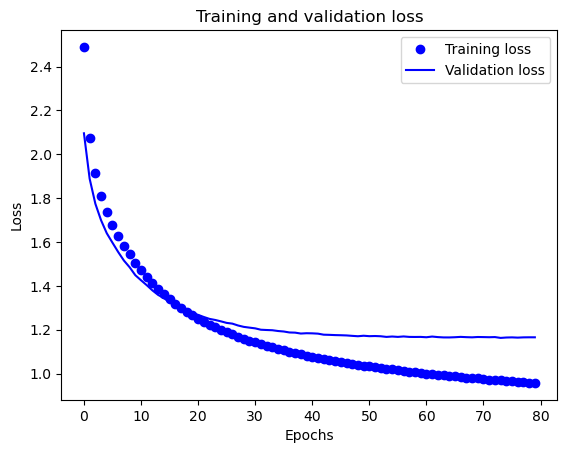

In [65]:
plt.plot(epochs, history['loss'], 'bo', label='Training loss')
plt.plot(epochs, history['val_loss'], 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

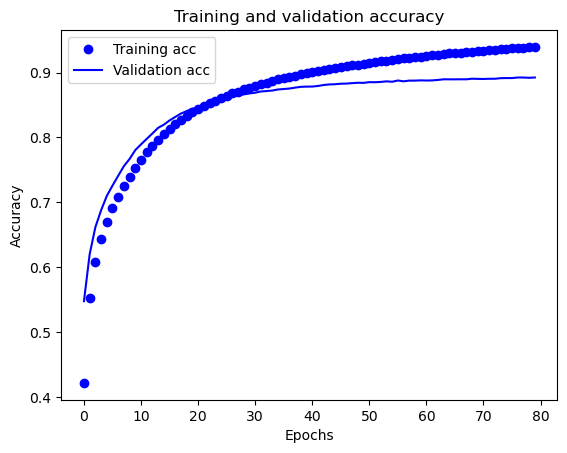

In [66]:
plt.plot(epochs, history['accuracy'], 'bo', label='Training acc')
plt.plot(epochs, history['val_accuracy'], 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Application

In [67]:
def greedy_decode(model, src_seq, max_len):
    src_embs = model.embedding(src_seq)
    memory = model.transformer.encoder(src_embs)
    tgt_seq = torch.LongTensor([2])  # <s>
    tgt_embs = model.embedding(tgt_seq)
    for i in range(max_len-1):
        tgt_mask = nn.Transformer.generate_square_subsequent_mask(
            tgt_embs.size(dim=0))
        tgt_output = model.transformer.decoder(tgt_embs,
                                               memory,
                                               tgt_mask)
        char_prob = model.fc(tgt_output[-1])
        next_char = torch.argmax(char_prob)
        tgt_seq = torch.cat(
            (tgt_seq,
             torch.unsqueeze(next_char, dim=0)), dim=0)
        tgt_embs = model.embedding(tgt_seq)
        if next_char.item() == 3:  # </s>
            break
    return tgt_seq[1:]

In [68]:
def translate(model, src_sentence):
    model.eval()
    src = seqs2tensors([src_sentence], token2idx)[0]
    num_chars = src.size(dim=0)
    tgt_chars = greedy_decode(
        model, src, max_len=num_chars + 20)
    tgt_chars = tensors2seqs([tgt_chars], idx2token)[0]
    if tgt_chars[-1] == '</s>':
        tgt_chars = tgt_chars[:-1]
    tgt_str = ''.join(tgt_chars)
    return tgt_str

In [69]:
tgt_sent = translate(translator, "Viens manger")
tgt_sent

'Come eat this food.'

In [70]:
tgt_sent = translate(translator, "Redkalösköldsfklöte !")
tgt_sent

'Contratle down.'

## Save model

In [72]:
torch.save(translator.state_dict(), 'simple_params_20240622.pth')